In [17]:
import numpy as np
from skimage import io, draw, measure
from matplotlib import pyplot as plt
import torch

from loader.base import BaseMatchDataset
from loader import utils
import tqdm
import time
import os
import h5py
from multiprocessing import Pool

from papyrus_matching.train import LitPapyrusTR
from loader.base import process_pair

In [3]:
%cd ..

/raid/homes/nicola.messina/workspace/papyri/papyrus-matching


/raid/homes/nicola.messina/anaconda3/envs/papyri/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [13]:
class InferenceDataset(BaseMatchDataset):
    def __init__(self, root_dir, image_name, side=384, transform=None, mask_transform=None, perimeter_points=64, pad=15):
        super().__init__(root_dir, side, transform, perimeter_points, pad)
        self.mask_transform = mask_transform
        
        self.image_id = image_name.replace(".png", "")
        # self.image_ids = [i for i in self.image_ids if self.check_image(i)]

        self.contours = self.get_contours(self.image_id)
        self.touch_points = self.get_all_touch_points(self.image_id, self.contours, pad=self.pad, force=False)
        self.touch_points = self.filter_touch_points(self.image_id, self.touch_points, self.side, force=True)

    def __len__(self):
        return len(self.touch_points)

    def __getitem__(self, idx):
        # load image
        image_id = self.image_id
        rgba_path = self.root_dir / 'rgba' / f'{image_id}.png'
        rgba = io.imread(rgba_path)

        # get contours and touch points
        contours = self.contours
        (a_idx, b_idx), a_contact, b_contact, delta = self.touch_points[idx]
        a_idx, b_idx = int(a_idx), int(b_idx)
        a_contour, b_contour = contours[a_idx], contours[b_idx]

        # find the coordinates of pixels to copy from the original image
        def _prepare_patch(cropped):
            if cropped:
                # use self.side to define the size of the crop
                side = self.side
            else:
                # prepare a larger patch so that both fragments are fully contained in it
                width_a = a_contour[:, 1].max() - a_contour[:, 1].min()
                width_b = b_contour[:, 1].max() - b_contour[:, 1].min()
                height_a = a_contour[:, 0].max() - a_contour[:, 0].min()
                height_b = b_contour[:, 0].max() - b_contour[:, 0].min()
                side = int(np.ceil(max(width_a + width_b, height_a + height_b))) + 2 * self.pad

            # make an empty transparent image
            shape = (side, side, 4)
            crop_rgba = np.zeros(shape, dtype=np.uint8)

            half_side = side // 2
            half_delta = delta / 2

            # move the contours such that they are centered in the crop
            t_a = - a_contact + half_side - self.pad * half_delta
            t_b = - b_contact + (side - half_side) + self.pad * (delta - half_delta)
            moved_a_contour = a_contour + t_a
            moved_b_contour = b_contour + t_b

            a_row_indices, a_col_indices = draw.polygon(moved_a_contour[:, 0], moved_a_contour[:, 1], shape=shape)
            b_row_indices, b_col_indices = draw.polygon(moved_b_contour[:, 0], moved_b_contour[:, 1], shape=shape)

            a_dst_y = a_row_indices.astype(int)
            a_dst_x = a_col_indices.astype(int)
            a_src_y = (a_row_indices - t_a[0]).astype(int)
            a_src_x = (a_col_indices - t_a[1]).astype(int)

            b_dst_y = b_row_indices.astype(int)
            b_dst_x = b_col_indices.astype(int)
            b_src_y = (b_row_indices - t_b[0]).astype(int)
            b_src_x = (b_col_indices - t_b[1]).astype(int)

            crop_rgba[a_dst_y, a_dst_x] = rgba[a_src_y, a_src_x]
            crop_rgba[b_dst_y, b_dst_x] = rgba[b_src_y, b_src_x]

            if cropped and self.transform:
                mask_a = np.zeros(shape[:2], dtype=np.float32)
                mask_b = np.zeros(shape[:2], dtype=np.float32)
                mask_a[a_dst_y, a_dst_x] = 1.0
                mask_b[b_dst_y, b_dst_x] = 1.0
                mask_a = self.mask_transform(mask_a[:, :, None])
                mask_b = self.mask_transform(mask_b[:, :, None])
                crop_a = self.transform(crop_rgba) * mask_a
                crop_b = self.transform(crop_rgba) * mask_b
                crop_rgba = crop_a + crop_b
                
                # crop_mask = self.transform(crop_mask)

            # ensure when the alpha is zero, the rgb is also zero
            zero_alpha = crop_rgba[3, :, :] == 0
            crop_rgba[:3, zero_alpha] = 0

            return crop_rgba

        cropped_patch = _prepare_patch(cropped=True)
        full_image = _prepare_patch(cropped=False)

        return cropped_patch, full_image

In [14]:
root = 'data/for_inference'
image_name = 'PC133 recto 01 A+B --- 09-04-2013.png'
from torchvision import transforms as T
transf = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
])
mask_transf = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224)),
])
dset = InferenceDataset(root, image_name, pad=15, transform=transf, mask_transform=mask_transf)

[INFO] Skipping touch point #0 in PC133 recto 01 A+B --- 09-04-2013.
[INFO] Skipping touch point #1 in PC133 recto 01 A+B --- 09-04-2013.
[INFO] Skipping touch point #2 in PC133 recto 01 A+B --- 09-04-2013.
[INFO] Skipping touch point #3 in PC133 recto 01 A+B --- 09-04-2013.
[INFO] Skipping touch point #4 in PC133 recto 01 A+B --- 09-04-2013.
[INFO] Skipping touch point #5 in PC133 recto 01 A+B --- 09-04-2013.
[INFO] Skipping touch point #6 in PC133 recto 01 A+B --- 09-04-2013.
[INFO] Skipping touch point #7 in PC133 recto 01 A+B --- 09-04-2013.
[INFO] Skipping touch point #8 in PC133 recto 01 A+B --- 09-04-2013.
[INFO] Skipping touch point #9 in PC133 recto 01 A+B --- 09-04-2013.
[INFO] Skipping touch point #10 in PC133 recto 01 A+B --- 09-04-2013.
[INFO] Skipping touch point #11 in PC133 recto 01 A+B --- 09-04-2013.
[INFO] Skipping touch point #12 in PC133 recto 01 A+B --- 09-04-2013.
[INFO] Skipping touch point #13 in PC133 recto 01 A+B --- 09-04-2013.
[INFO] Skipping touch point #1

In [7]:
# load the model
model_path = "runs/lightning_logs/version_3/checkpoints/epoch=26-step=4293.ckpt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LitPapyrusTR.load_from_checkpoint(model_path)
encoder = model.eval().to(device)


  2%|▏         | 1/54 [03:42<3:16:35, 222.55s/it]

Loading time: 222.467s, Inference time: 0.023s
0.9375415444374084


  2%|▏         | 1/54 [03:44<3:18:06, 224.27s/it]


KeyboardInterrupt: 

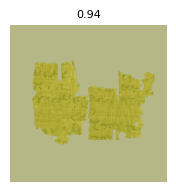

In [15]:
# show images organizing them in a grid
fig = plt.figure(figsize=(24, 24))
num_samples = min(100, len(dset))

for i in tqdm.trange(num_samples):
    start = time.time()
    data = dset[i]
    end_loading = time.time()
    patch, image = data
    # patch = (patch.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
    # image = (image.numpy().transpose(1, 2, 0) * 255).astype(np.uint8)

    # draw a red dot at the center of the mask and rgba
    # center = (patch.shape[0] // 2, patch.shape[1] // 2)
    # rr, cc = draw.disk(center, 5, shape=patch.shape[:2])
    # patch[rr, cc] = [255, 0, 0, 255]

    score = encoder(patch.unsqueeze(0).to(device))
    score = torch.sigmoid(score).squeeze().cpu().item()
    end_inference = time.time()
    print(f"Loading time: {end_loading - start:.3f}s, Inference time: {end_inference - end_loading:.3f}s")

    ax = fig.add_subplot(10, 10, i + 1)
    # disable axis
    ax.axis('off')
    print(score)
    color = plt.cm.viridis(score)
    color = np.concatenate((color[:3], [1.0]))
    # add the color to the image, with 0.5 alpha
    image = (0.5 * image + 0.5 * np.array(color[None, None, :]) * 255).astype(np.uint8)
    ax.set_title(f"{score:.2f}", fontdict={'size': 8})
    ax.imshow(image)